In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import pandas
import os
import numpy as np
import pickle as pk
import sklearn as sk
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2023-05-23 13:25:36.041267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 13:25:36.718529: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pandas.read_csv("./../codes/tuke-codes-representation")
data.dropna()
data = data[2:]
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

[]
0 Physical GPU, 0 Logical GPUs


2023-05-23 13:25:37.707687: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-23 13:25:37.707713: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: Anonymous
2023-05-23 13:25:37.707718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: Anonymous
2023-05-23 13:25:37.707808: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-05-23 13:25:37.707824: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-05-23 13:25:37.707827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [3]:
typeMap = {}
c = 1
for i in range(data.shape[0]):
    file = "".join(filter(str.isalpha, data.iloc[i,0].split(".")[0]))
    funcName = data.iloc[i,0].split(".")[-2]
    if not typeMap.get(file+funcName, 0):
        typeMap[file+funcName] = c
        c += 1
    data.iloc[i,0] = typeMap[file+funcName]
data.head()

,type,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15
2,1,0.109037,0.120678,0.086514,0.028207,-0.148110,0.032928,0.073715,0.004862,0.010571,0.228280,0.195455,-0.077252,-0.281604,-0.059144,0.187242,-0.061434
3,2,0.487315,-0.095646,0.068539,-0.137434,0.044939,0.118012,0.047898,-0.090840,0.105718,0.430358,0.741373,-0.052656,-0.472899,0.234022,0.289644,-0.216068
4,1,0.079750,0.107116,0.090714,0.062954,-0.289380,0.018924,0.026372,0.042391,-0.029929,0.261187,0.219219,-0.118201,-0.271720,0.015057,0.198539,-0.030133
5,1,0.183542,0.226497,0.686212,-0.412960,0.060868,0.417013,0.290572,0.383199,-0.052106,0.243412,0.786468,-0.563924,-0.350164,0.348901,0.898638,-0.309622
6,3,0.080565,0.128648,0.196643,0.119514,-0.311092,-0.012558,0.076501,0.115046,0.018845,0.286420,0.311308,-0.123405,-0.372587,-0.014799,0.192423,-0.073891


In [4]:
frames = [data.loc[data["type"] == x].iloc[0:,1:].values.tolist() for x in range(1,594)]
with open("data.pkl", "wb") as d:
    pk.dump(frames, d)
    d.close()

In [8]:
x = []
y = []
for i in frames[1:]:
    for j in frames[1:]:
        minlen = min(len(i), len(j))
        truthy = i == j
        for k in range(minlen):
            x.append([i[k],j[k]])
            y.append(truthy)

In [18]:
tf.random.set_seed(12)
tf.keras.backend.clear_session()
x = np.array(x).astype("float64")
y = np.array(y).astype("bool")

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=23,shuffle=True)
x_train_0 = np.array([x[0] for x in x_train])
x_train_1 = np.array([x[1] for x in x_train])
x_test_0 = np.array([x[0] for x in x_test])
x_test_1 = np.array([x[1] for x in x_test])

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

def create_network(input_size):
    # Define the tensors for the two input images
    input_1 = Input(shape=(input_size,))
    input_2 = Input(shape=(input_size,))

    # Neural Network
    model = tf.keras.Sequential()
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))

    # Generate the encodings (feature vectors) for the two images
    encoded_1 = model(input_1)
    encoded_2 = model(input_2)

    # Add a customized layer to compute the Euclidean distance between the encodings
    distance = Lambda(euclidean_distance)([encoded_1, encoded_2])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid')(distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[input_1, input_2], outputs=prediction)

    # return the model
    return siamese_net

# Create the siamese network
model = create_network(16)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64)           1088        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['sequential[0][0]',         

In [12]:
history = model.fit([x_train_0,x_train_1], y_train,validation_data=([x_test_0,x_test_1],y_test), epochs=40)

Epoch 1/40
11650/11650 [==============================] - 11s 915us/step - loss: 0.4743 - accuracy: 0.9590 - val_loss: 0.3018 - val_accuracy: 0.9871
Epoch 2/40
11650/11650 [==============================] - 11s 920us/step - loss: 0.1295 - accuracy: 0.9876 - val_loss: 0.0920 - val_accuracy: 0.9871
Epoch 3/40
11650/11650 [==============================] - 11s 939us/step - loss: 0.0672 - accuracy: 0.9876 - val_loss: 0.0839 - val_accuracy: 0.9871
Epoch 4/40
11650/11650 [==============================] - 11s 944us/step - loss: 0.0663 - accuracy: 0.9876 - val_loss: 0.0765 - val_accuracy: 0.9871
Epoch 5/40
11650/11650 [==============================] - 11s 983us/step - loss: 0.0653 - accuracy: 0.9876 - val_loss: 0.0688 - val_accuracy: 0.9871
Epoch 6/40
11650/11650 [==============================] - 11s 941us/step - loss: 0.0643 - accuracy: 0.9876 - val_loss: 0.0636 - val_accuracy: 0.9871
Epoch 7/40
11650/11650 [==============================] - 11s 969us/step - loss: 0.0628 - accuracy: 0.9876

In [ ]:

y_pred = model.evaluate([x_test_0, x_test_1],y_test)


In [2]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming that 'model' is your trained model and 'X_test', 'y_test' are your test data.

# Predict the probabilities for the test data
y_pred_prob = model.predict([x_test_0, x_test_1]).ravel()

# Predict the classes for the test data
y_pred = np.round(y_pred_prob)

# Print precision, recall, and F1-score
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("AUC-ROC:", roc_auc)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

NameError: name 'model' is not defined

NameError: name 'history' is not defined

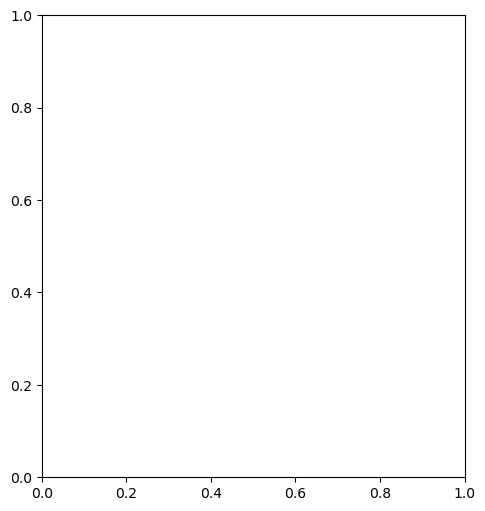

In [3]:
import matplotlib.pyplot as plt

# Assuming that 'model' is your trained model, and 'history' is the returned History object from model.fit
# e.g., history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20)

# Plot training & validation accuracy values
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [4]:
history.history


NameError: name 'history' is not defined